### Итоговый мини-проект по курсу "Программирование на языке Python"

#### Выполнил: *Соколов Герман Олегович*

**Задача: **

* Дополнить существующий dataset данными из интернета

Исходный dataset - результаты теннисных матчей ATP среди мужчин в 2015 году

Дополнительные данные - архив коэффициентов ставок на теннисные матчи в 2015 году

**Основные шаги: **

* Написать функцию для "автоматического хождения" по страницам и "собирания" коэффициентов с сайта за разные даты 2015 года
* Обработка собранной информации:
 - создание pandas датафрейма
 - определение победителя и проигравшего
 - определение значения переменной target - сбылись или нет прогнозы людей ставивших на матч (1 или 0)
* Некоторая визуализация данных по ставкам
* Добавление данных в исходный датафрейм

In [1]:
import datetime
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
%matplotlib inline

Так как этот мини-проект из серии скучных, но необходимых (для собственных целей) и рисунков будет немного, то хотя бы добавлю пока эту картинку, чтобы было попроще жить:

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.firestock.ru/wp-content/uploads/2013/09/firestock_girl_tennis_03092013-700x775.jpg", 
      width = 400)

Определяю начальную и конечную даты для "собирания" коэффициентов:

In [3]:
d1 = datetime.date(2015, 1, 1)
d2 = datetime.date(2015, 12, 31)

Функция, которая будет заниматься автоматическим хождением по сайтам и извлечением нужной информации:

In [4]:
def create_df(date_start, date_end):
    matches = {} # Сначала собираю данные в словарик (ключ - пара игроков в матче, значения - коэфф, счет, дата)
    days = (date_end - date_start).days
    for d in range(0, days + 1):
        search_date = date_start + datetime.timedelta(d)
        url_date = search_date.isoformat() # В названиях страниц меняется только последнее значение - это дата
        url = requests.get('http://data.nowgoal.com/tennis/oddsHistory.htm?date=' + url_date)
        if url.ok == True: 
            print(url_date)
            names, bets, scores = [], [], []
            page = BeautifulSoup(url.text, 'html.parser')
            if page.html.body.table != None:  # Страница может работать, но данных там может не быть
                lines = page.html.body.table.findAll('a')
                count = 0
            else:
                continue
            for line in lines:
                if line.has_attr('target') and \
                   len(line.text) > 0:
                    try:
                        bet365 = float(lines[count + 1].text)
                    except ValueError:
                        bet365 = ""
                    if "&" in line.parent.text:
                        if line.parent.text == lines[count+1].parent.text:
                            count += 1
                            continue
                        else:
                            name = line.parent.text
                    else:
                        name = line.text
                    
                    names.append(name.lower())
                    bets.append(bet365)
                    scores.append(int(line.parent.parent.find('b').text))
                count += 1
            for i in range(0, len(names)-1, 2):
                match = (names[i], names[i + 1])
                matches[match] = [bets[i], bets[i + 1], scores[i], scores[i+1], url_date]
    
    # Для удобства представляю словарик со значениями в виде датафрейма:
    df = pd.DataFrame(columns = ["date", "player1_name", "player2_name", 
                             "player1_k", "player2_k", "player1_g", "player2_g"])
    df["date"] = [list(x)[-1] for x in matches.values()]
    df["player1_name"] = [list(x)[0] for x in matches.keys()]
    df["player2_name"] = [list(x)[1] for x in matches.keys()]
    df["player1_k"] = [list(x)[0] for x in matches.values()] # коэффициент игрока 1
    df["player2_k"] = [list(x)[1] for x in matches.values()]
    df["player1_g"] = [list(x)[2] for x in matches.values()] # кол-во геймов выигранных игроком 1
    df["player2_g"] = [list(x)[3] for x in matches.values()]
    df.date = pd.to_datetime(df.date.astype(str), format='%Y-%m-%d')
    df.sort_values(["date"], inplace=True)
    
    return df

Удобно было бы обработать полученный датафрейм, чтобы понять кто победитель, и оправдались ли ожидания играющих на тотализаторе: 

In [5]:
def process_df(df):
    pd.options.mode.chained_assignment = None # выключаю ненужные предупреждения pandas
    # удаляю игры в парах (2 на 2) - они не нужны:
    df = df.loc[~((df.player1_name.str.contains("&")) | (df.player2_name.str.contains("&"))), :] 
    df = df.loc[(df.player1_k != "") & (df.player2_k != ""), :] # избавляюсь от отсутствующих коэффициентов
    df[["winner_name", "loser_name", "winner_k", "loser_k"]] = \
    df.loc[df.player1_g > df.player2_g, ["player1_name", "player2_name", "player1_k", "player2_k"]]

    df.ix[df.player1_g < df.player2_g, "winner_name"] = df.ix[df.player1_g < df.player2_g, "player2_name"]
    df.ix[df.player1_g < df.player2_g, "loser_name"] = df.ix[df.player1_g < df.player2_g, "player1_name"]
    df.ix[df.player1_g < df.player2_g, "winner_k"] = df.ix[df.player1_g < df.player2_g, "player2_k"]
    df.ix[df.player1_g < df.player2_g, "loser_k"] = df.ix[df.player1_g < df.player2_g, "player1_k"]

    # если у игрока меньше коэффициент -> на него было поставлено больше денег -> зрители ожидают, что он выиграет
    # если ожидания оправдались, то target == 1 (действительно нужно было делать ставку), иначе = 0
    df["target"] = 0
    df.loc[df.winner_k < df.loser_k, "target"] = 1 

    df = pd.DataFrame(df, columns = ["date", 'winner_name', "loser_name", "winner_k", "loser_k", "target"])
    df.winner_k = pd.to_numeric(df["winner_k"])
    df.loser_k = pd.to_numeric(df["loser_k"])
    df.index = list(range(df.shape[0]))
    
    return df

Запускаем функцию ***create_df*** для сбора информации за 2015 год

In [6]:
df = create_df(d1, d2)

2015-01-01
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07
2015-01-08
2015-01-09
2015-01-10
2015-01-11
2015-01-12
2015-01-13
2015-01-14
2015-01-15
2015-01-16
2015-01-17
2015-01-18
2015-01-19
2015-01-20
2015-01-21
2015-01-22
2015-01-23
2015-01-24
2015-01-25
2015-01-26
2015-01-27
2015-01-28
2015-01-29
2015-01-30
2015-01-31
2015-02-01
2015-02-02
2015-02-03
2015-02-04
2015-02-05
2015-02-06
2015-02-07
2015-02-08
2015-02-09
2015-02-10
2015-02-11
2015-02-12
2015-02-13
2015-02-14
2015-02-15
2015-02-16
2015-02-17
2015-02-18
2015-02-19
2015-02-20
2015-02-21
2015-02-22
2015-02-23
2015-02-24
2015-02-25
2015-02-26
2015-02-27
2015-02-28
2015-03-01
2015-03-02
2015-03-03
2015-03-04
2015-03-05
2015-03-06
2015-03-07
2015-03-08
2015-03-09
2015-03-10
2015-03-11
2015-03-12
2015-03-13
2015-03-14
2015-03-15
2015-03-16
2015-03-17
2015-03-18
2015-03-19
2015-03-20
2015-03-21
2015-03-22
2015-03-23
2015-03-24
2015-03-25
2015-03-26
2015-03-27
2015-03-28
2015-03-29
2015-03-30
2015-03-31
2015-04-01

Так выглядит полученный dataset:

In [7]:
df.head()

,date,player1_name,player2_name,player1_k,player2_k,player1_g,player2_g
5591,2015-01-01,milos raonic,fabio fognini,1.33,3.25,2,0
2996,2015-01-01,richard gasquet,john isner,,,2,0
4894,2015-01-01,tomas berdych,david ferrer,1.72,2,2,1
4661,2015-01-02,stan wawrinka,nicolas almagro,1.25,3.75,2,0
1777,2015-01-02,tomas berdych,milos raonic,,,2,0


Теперь делаем обработку с помощью функции ***process_df*** : 

In [8]:
df_proc = process_df(df)
df_proc.head()

,date,winner_name,loser_name,winner_k,loser_k,target
0,2015-01-01,milos raonic,fabio fognini,1.33,3.25,1
1,2015-01-01,tomas berdych,david ferrer,1.72,2.00,1
2,2015-01-02,stan wawrinka,nicolas almagro,1.25,3.75,1
3,2015-01-04,n. vikhlyantseva,anna-lena friedsam,3.50,1.28,0
4,2015-01-04,varvara lepchenko,samantha stosur,3.00,1.36,0


Посмотрим, как распределены коэффициенты для "среднего" случая, то есть когда нет супер - явного фаворита (такие игры вообще-то неинтересны в принципе). Для этого ограничиваю макисмальное значение коэффициента значением **5**:

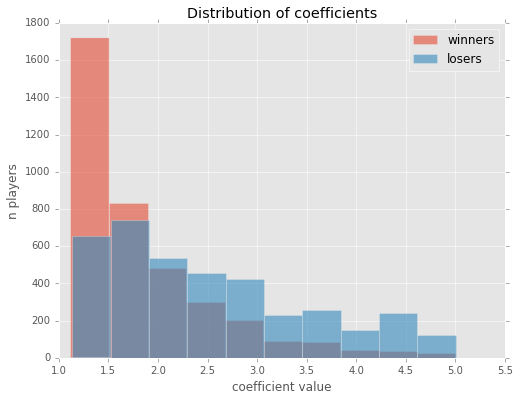

In [9]:
y_win = df_proc.winner_k[(df_proc.winner_k <= 5) & (df_proc.loser_k <= 5)]
y_los = df_proc.loser_k[(df_proc.winner_k <= 5) & (df_proc.loser_k <= 5)]
plt.style.use("ggplot")
plt.figure(figsize = (8,6))
plt.hist(y_win.values, alpha = 0.6, bins = 10)
plt.hist(y_los.values, alpha = 0.6, bins = 10)
plt.title("Distribution of coefficients")
plt.xlabel("coefficient value")
plt.ylabel("n players")
plt.legend(["winners", "losers"])

Видно, что у победивших ожидаемо ниже коэффициенты - почти половина победивших имеет коэффициенты ниже 1.5

Также можно посмотреть все комбинации коэффициентов в матчах используя scatterplot:

(1, 5)

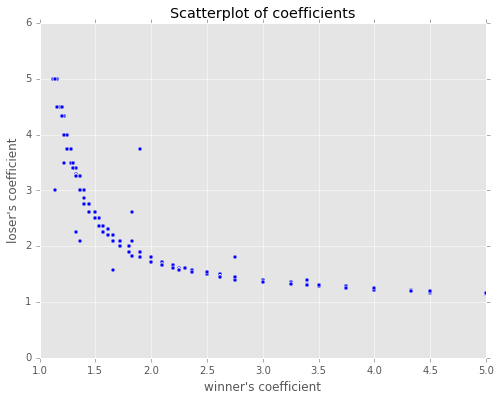

In [10]:
plt.figure(figsize = (8,6))
plt.scatter(y_win, y_los, s = 15)
plt.title("Scatterplot of coefficients")
plt.xlabel("winner's coefficient")
plt.ylabel("loser's coefficient")
plt.xlim([1, 5])

Видно, что присутствует некоторое количество аутлаеров, а такого быть не должно, иначе сайты - тотализаторы что-то делают не так, во что трудно поверить. Скорей всего данный "косяк" связан с неправильными данными на сайте (это действительно оказывается так после ручной проверки сайта).

In [11]:
df_proc.loc[((df_proc.winner_k < 1.7) & (df_proc.loser_k < 1.9)) | 
            ((df_proc.winner_k > 1.7) & (df_proc.loser_k > 2.5)), :]

,date,winner_name,loser_name,winner_k,loser_k,target
2753,2015-07-15,jan hernych,ryan harrison,1.66,1.57,0
2758,2015-07-15,yuichi sugita,adrien bossel,2.25,5.50,1
2760,2015-07-15,sorana cirstea,patricia maria tig,1.90,3.75,1
2762,2015-07-15,john-patrick smith,yuichi sugita,1.83,2.62,1


Да, видно что аутлаеры связаны с каким-то одним днем (15 июля 2015), значит его можно вообще убрать из датафрейма.

(1, 5)

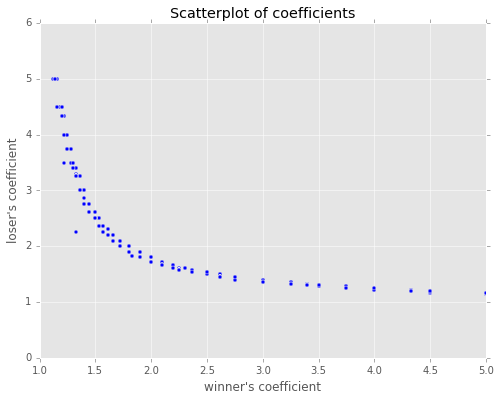

In [12]:
df_proc = df_proc[df_proc.date != pd.datetime(year=2015, month = 7, day = 15)]
df_proc.index = list(range(df_proc.shape[0]))
y_win = df_proc.winner_k[(df_proc.winner_k <= 5) & (df_proc.loser_k <= 5)]
y_los = df_proc.loser_k[(df_proc.winner_k <= 5) & (df_proc.loser_k <= 5)]
plt.figure(figsize = (8,6))
plt.scatter(y_win, y_los, s = 15)
plt.title("Scatterplot of coefficients")
plt.xlabel("winner's coefficient")
plt.ylabel("loser's coefficient")
plt.xlim([1, 5])

Так-то лучше!

Теперь можно добавить собранные данные к первоначальному датасету:

In [13]:
url_atp_main = "https://raw.githubusercontent.com/german3d/tennis_atp/master/atp_matches_2015.csv"
url_atp_chal = "https://raw.githubusercontent.com/german3d/tennis_atp/master/atp_matches_qual_chall_2015.csv"
url_atp_fut = 'https://raw.githubusercontent.com/german3d/tennis_atp/master/atp_matches_futures_2015.csv'

df_atp = pd.read_csv(url_atp_main)

In [14]:
df_atp.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,2015-329,Tokyo,Hard,32,A,20151005,1,104527,1,NaN,...,1,2,2,71,46,33,10,10,2,5
1,2015-329,Tokyo,Hard,32,A,20151005,2,105147,NaN,WC,...,14,1,4,96,52,25,23,13,12,19
2,2015-329,Tokyo,Hard,32,A,20151005,3,105572,NaN,Q,...,7,15,7,128,74,60,27,18,9,11
3,2015-329,Tokyo,Hard,32,A,20151005,4,105311,NaN,NaN,...,6,9,5,85,42,27,21,13,4,8
4,2015-329,Tokyo,Hard,32,A,20151005,5,104468,3,NaN,...,6,0,5,61,33,24,10,10,1,5


В датасете много лишних параметров, поэтому использую только необходимые столбцы:

In [15]:
columns_to_use = ["surface", "tourney_level", "tourney_date", "winner_name", "loser_name", 
                  "winner_ht", "winner_age", "winner_rank", "winner_rank_points", 
                  "loser_ht", "loser_age", "loser_rank", "loser_rank_points"]

df_atp = pd.DataFrame(df_atp, columns=columns_to_use)

for url in [url_atp_chal, url_atp_fut]:
    df_temp = pd.read_csv(url)
    df_temp = pd.DataFrame(df_temp, columns = columns_to_use)
    df_atp = pd.concat([df_atp, df_temp], axis=0, join='outer', ignore_index = True)

df_atp.tourney_date = pd.to_datetime(df_atp.tourney_date.astype(str), format='%Y%m%d')
df_atp.sort_values(["tourney_date"], inplace=True)
df_atp.dropna(inplace = True)
df_atp.index = list(range(df_atp.shape[0]))
df_atp.winner_name = df_atp.winner_name.str.lower()
df_atp.loser_name = df_atp.loser_name.str.lower()

Добавление новых столбцов:

In [16]:
df_atp = pd.merge(df_atp, df_proc, on=["winner_name", "loser_name"])
df_atp.drop("date", axis=1, inplace=True)
df_atp.drop_duplicates(subset = ["winner_name", "loser_name", "winner_k", "loser_k"], inplace=True)

**И наконец-то финальный набор с данными получен!**

In [17]:
df_atp.head()

,surface,tourney_level,tourney_date,winner_name,loser_name,winner_ht,winner_age,winner_rank,winner_rank_points,loser_ht,loser_age,loser_rank,loser_rank_points,winner_k,loser_k,target
0,Hard,A,2015-01-04,james duckworth,gilles simon,183,22.956879,125,430,183,30.023272,21,1730,4.50,1.18,0
1,Hard,A,2015-01-04,grigor dimitrov,martin klizan,188,23.641342,11,3645,190,25.486653,34,1094,1.28,3.50,1
2,Hard,A,2015-01-04,roger federer,james duckworth,185,33.409993,2,9625,183,22.956879,125,430,1.05,11.00,1
3,Hard,A,2015-01-04,kei nishikori,steve johnson,178,25.018480,5,5025,188,25.032170,37,999,1.08,8.00,1
5,Hard,A,2015-01-04,milos raonic,mikhail kukushkin,196,24.024641,8,4440,183,27.028063,69,705,1.22,4.00,1


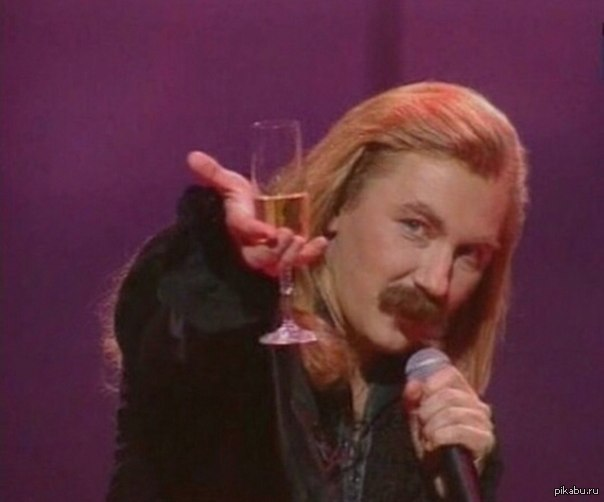

In [18]:
Image("http://s4.pikabu.ru/post_img/big/2014/12/07/11/1417978240_1193688783.jpg", 
      width = 300)